# 1 Prepare

In [4]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
%matplotlib inline

sns.set()

NtwDens = pandas.read_excel('Tables/NtwDensTable.xlsx')
NodeAttrs = pandas.read_excel('Tables/NodeAttrTable.xlsx')
RegionsTable = pandas.read_excel('Data/Keys.xlsx', sheet_name = 'Regions')

GlobalDens = NtwDens.query('region_x == "World"').\
    drop(columns = ['region_x', 'region_y'])
GlobalAttrs = NodeAttrs.query('region_x == "World"').\
    drop(columns = ['region_x', 'region_y'])

IntraRegionalAttrs = NodeAttrs.query('(region_x == region_y) and (region_x != "World")').\
    drop(columns = ['region_y']).\
    rename(columns = {'region_x': 'region'})
InterRegionalAttrs = NodeAttrs.query('region_x != region_y')

AreasInRegions = []
for region in RegionsTable['REGION_CODE'].unique():
    AreasInRegions.extend([
        (region, area) for area in RegionsTable.query('REGION_CODE == @region')['ISO3'].tolist()
    ])
AreasInRegions = pandas.DataFrame(AreasInRegions, columns = ['region', 'ISO3'])

RegionsGdp = pandas.read_excel('Data/GDP2019.xlsx', sheet_name = 'intra-region').\
    sort_values('avg_gdp', ascending = False).\
    reset_index(drop = True).\
    drop(columns = ['n'])
InterRegionsGdp = pandas.read_excel('Data/GDP2019.xlsx', sheet_name = 'inter-region').\
    sort_values(['avg_x', 'avg_y'], ascending = False).\
    reset_index(drop = True).\
    drop(columns = ['n_x', 'n_y', 'n_t', 'avg_t'])

AreasGdp = pandas.read_excel('Data/GDP2019.xlsx', sheet_name = 'area').\
    sort_values('gdp', ascending = False).\
    reset_index(drop = True)

X_AXIS = ['Jan-20', '', '', 'Apr-20', '', '', 'Jul-20', '', '', 'Oct-20', '', '', 
          'Jan-21', '', '', 'Apr-21', '', '', 'Jul-21', '', '', 'Oct-21', '', 'Dec-21']

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
def show_only_min_and_max(pdata):
    result = pdata.copy()
    min_values = result.min(axis = 1)
    max_values = result.max(axis = 1)

    for row_i in range(0, len(result)):
        for col_i in range(0, len(result.columns)):
            if result.iloc[row_i, col_i] > min_values[row_i] and result.iloc[row_i, col_i] < max_values[row_i]:
                result.iloc[row_i, col_i] = ''
            else:
                result.iloc[row_i, col_i] = '%.2f'%result.iloc[row_i, col_i]
    return result

plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['font.size'] = '16'
plt.rcParams['font.weight'] = 'bold'

# 2 Pandemic Impact on International Trade Network (Section 3.1)

## 2.1 Global Scale (Section 3.1.1)

In [6]:
GlobalVol = GlobalAttrs.\
    groupby(['year', 'month'])\
    [['ex_vol']].\
    sum().\
    rename(columns = {'ex_vol': 'vol'})

GlobalAll = GlobalDens.\
    merge(GlobalVol, on = ['year', 'month'])

GlobalRef = GlobalAll.\
    query('year == 2018 or year == 2019').\
    groupby('month').\
    mean().\
    drop(columns = ['year']).\
    rename(columns = {'ex_vol': 'vol'}).\
    reset_index()

GlobalYoY = GlobalAll.\
    query('year == 2020 or year == 2021').\
    merge(GlobalRef, on = 'month').\
    eval('''
        density = density_x / density_y - 1
        volume = vol_x / vol_y - 1
    ''').\
    filter(regex = r'^((?!_[xy]).)*$').\
    sort_values(['year', 'month'])

GlobalYoY.to_excel('Tables/GlobalYoY.xlsx', sheet_name = 'GlobalYoY', index = False)

## 2.2 Regional Scale (Section 3.1.2)

In [7]:
RegionalAll = AreasInRegions.\
    merge(GlobalAttrs, on = 'ISO3').\
    groupby(['year', 'month', 'region'])\
    [['ex_vol', 'im_vol', 'ex_pr', 'im_pr']].\
    agg({
        'ex_vol': numpy.sum,
        'im_vol': numpy.sum,
        'ex_pr': numpy.mean, 
        'im_pr': numpy.mean
    })

RegionalRef = RegionalAll.\
    query('year == 2018 or year == 2019').\
    reset_index().\
    groupby(['month', 'region']).\
    mean().\
    drop(columns = ['year']).\
    reset_index()

RegionalYoY = RegionalAll.\
    query('year == 2020 or year == 2021').\
    reset_index().\
    merge(RegionalRef, on = ['month', 'region']).\
    eval('''
        ex_vol = ex_vol_x / ex_vol_y - 1
        im_vol = im_vol_x / im_vol_y - 1
        ex_pr = ex_pr_x / ex_pr_y - 1
        im_pr = im_pr_x / im_pr_y - 1
    ''').\
    filter(regex = r'^((?!_[xy]).)*$').\
    sort_values(['region', 'year', 'month'])

writer = pandas.ExcelWriter('Tables/RegionalYoY.xlsx')
RegionalYoY.to_excel(writer, sheet_name = 'RegionalYoY', index = False)

In [8]:
AreasInRegions_NoCHN = AreasInRegions.\
    query('ISO3 != "CHN" and (region == "APQ" or region == "EAQ" or region == "DA")')

RegionalAll_NoCHN = AreasInRegions_NoCHN.\
    merge(GlobalAttrs, on = 'ISO3').\
    groupby(['year', 'month', 'region'])\
    [['ex_vol', 'im_vol', 'ex_pr', 'im_pr']].\
    agg({
        'ex_vol': numpy.sum,
        'im_vol': numpy.sum,
        'ex_pr': numpy.mean, 
        'im_pr': numpy.mean
    })

RegionalRef_NoCHN = RegionalAll_NoCHN.\
    query('year == 2018 or year == 2019').\
    reset_index().\
    groupby(['month', 'region']).\
    mean().\
    drop(columns = ['year']).\
    reset_index()

RegionalYoY_NoCHN = RegionalAll_NoCHN.\
    query('year == 2020 or year == 2021').\
    reset_index().\
    merge(RegionalRef_NoCHN, on = ['month', 'region']).\
    eval('''
        ex_vol = ex_vol_x / ex_vol_y - 1
        im_vol = im_vol_x / im_vol_y - 1
        ex_pr = ex_pr_x / ex_pr_y - 1
        im_pr = im_pr_x / im_pr_y - 1
    ''').\
    filter(regex = r'^((?!_[xy]).)*$').\
    sort_values(['region', 'year', 'month'])

RegionalYoY_NoCHN.to_excel(writer, sheet_name = 'RegionalYoY_NoCHN', index = False)
writer.save()

C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\3410921007.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = RegionalYoY[['region', 'year', 'month', 'ex_vol']].\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\3410921007.py:27: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = RegionalYoY_NoCHN[['region', 'year', 'month', 'ex_vol']].\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\3410921007.py:44: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = RegionalYoY[['region', 'year', 'month', 'im_vol']].\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\3410921007.py:61: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 

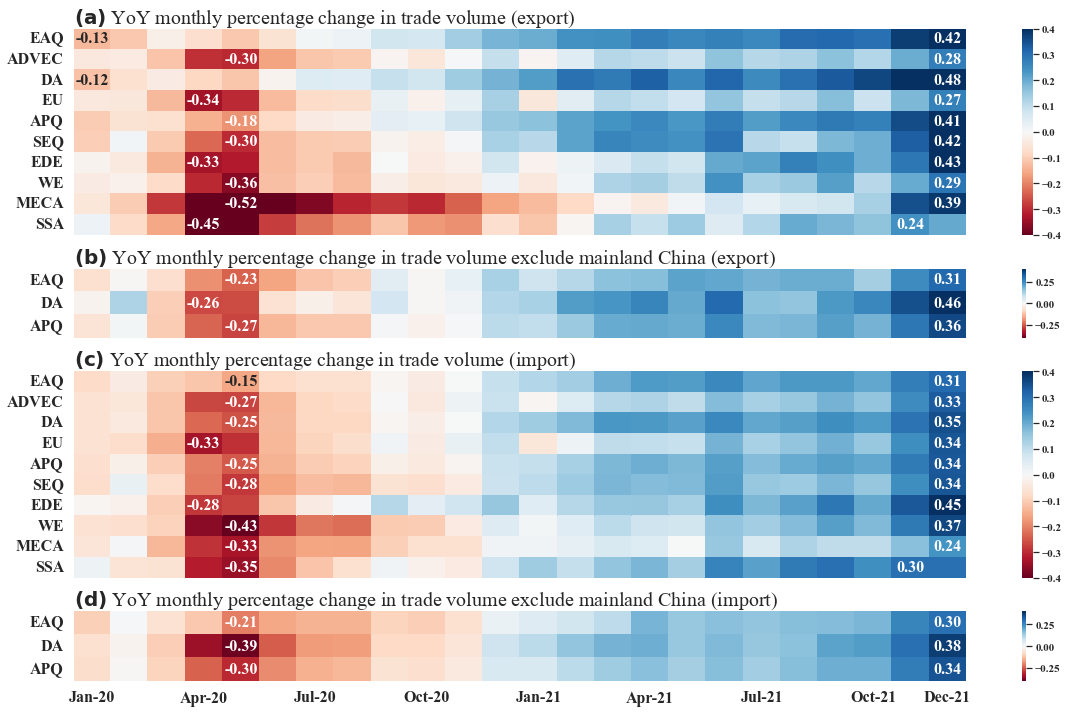

In [9]:
vmax = 0.4

fig = plt.figure(figsize = (20, 12))
plt.subplots_adjust(hspace = 40)

#--------------------------------------------------------------------------------------------------------
axes = plt.subplot2grid((20, 1), (0, 0), rowspan = 7)
axes.set_title(r'$\bf{(a)}$ YoY monthly percentage change in trade volume (export)', fontsize = 20, loc = 'left')

data = RegionalYoY[['region', 'year', 'month', 'ex_vol']].\
    pivot(index = 'region', columns = ['year', 'month'], values = 'ex_vol').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False)
pdata = data.iloc[:,1:-1]
pdata.index = data['region']

sns.heatmap(pdata.iloc[:], ax = axes, cmap='RdBu', annot = show_only_min_and_max(pdata), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes.set_xticklabels(labels = X_AXIS, visible = False)
axes.set_xlabel('')
axes.set_ylabel('')
axes.set_yticklabels(labels = axes.get_yticklabels(), rotation = 0, fontsize = 16)

#--------------------------------------------------------------------------------------------------------
axes = plt.subplot2grid((20, 1), (7, 0), rowspan = 3)
axes.set_title(r'$\bf{(b)}$ YoY monthly percentage change in trade volume exclude mainland China (export)', fontsize = 20, loc = 'left')

data = RegionalYoY_NoCHN[['region', 'year', 'month', 'ex_vol']].\
    pivot(index = 'region', columns = ['year', 'month'], values = 'ex_vol').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False)
pdata = data.iloc[:,1:-1]
pdata.index = data['region']

sns.heatmap(pdata.iloc[:], ax = axes, cmap='RdBu', annot = show_only_min_and_max(pdata), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes.set_xlabel('')
axes.set_ylabel('')
axes.set_xticklabels(labels = X_AXIS, visible = False)
axes.set_yticklabels(labels = axes.get_yticklabels(), rotation = 0, fontsize = 16)

#--------------------------------------------------------------------------------------------------------
axes = plt.subplot2grid((20, 1), (10, 0), rowspan = 7)
axes.set_title(r'$\bf{(c)}$ YoY monthly percentage change in trade volume (import)', fontsize = 20, loc = 'left')

data = RegionalYoY[['region', 'year', 'month', 'im_vol']].\
    pivot(index = 'region', columns = ['year', 'month'], values = 'im_vol').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False)
pdata = data.iloc[:,1:-1]
pdata.index = data['region']

sns.heatmap(pdata.iloc[:], ax = axes, cmap='RdBu', annot = show_only_min_and_max(pdata), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes.set_xlabel('')
axes.set_ylabel('')
axes.set_xticklabels(labels = X_AXIS, visible = False)
axes.set_yticklabels(labels = axes.get_yticklabels(), rotation = 0, fontsize = 16)

#--------------------------------------------------------------------------------------------------------
axes = plt.subplot2grid((20, 1), (17, 0), rowspan = 3)
axes.set_title(r'$\bf{(d)}$ YoY monthly percentage change in trade volume exclude mainland China (import)', fontsize = 20, loc = 'left')

data = RegionalYoY_NoCHN[['region', 'year', 'month', 'im_vol']].\
    pivot(index = 'region', columns = ['year', 'month'], values = 'im_vol').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False)
pdata = data.iloc[:,1:-1]
pdata.index = data['region']

sns.heatmap(pdata.iloc[:], ax = axes, cmap='RdBu', annot = show_only_min_and_max(pdata), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes.set_xlabel('')
axes.set_ylabel('')
axes.set_xticklabels(labels = X_AXIS, rotation = 0, fontsize = 16)
axes.set_yticklabels(labels = axes.get_yticklabels(), rotation = 0, fontsize = 16)

#--------------------------------------------------------------------------------------------------------
plt.show()
fig.savefig(r'Plots/Figure B.1.jpg', bbox_inches = 'tight', dpi = 300)

C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\784587532.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = RegionalYoY[['region', 'year', 'month', 'ex_pr']].\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\784587532.py:27: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = RegionalYoY_NoCHN[['region', 'year', 'month', 'ex_pr']].\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\784587532.py:44: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = RegionalYoY[['region', 'year', 'month', 'im_pr']].\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\784587532.py:61: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels 

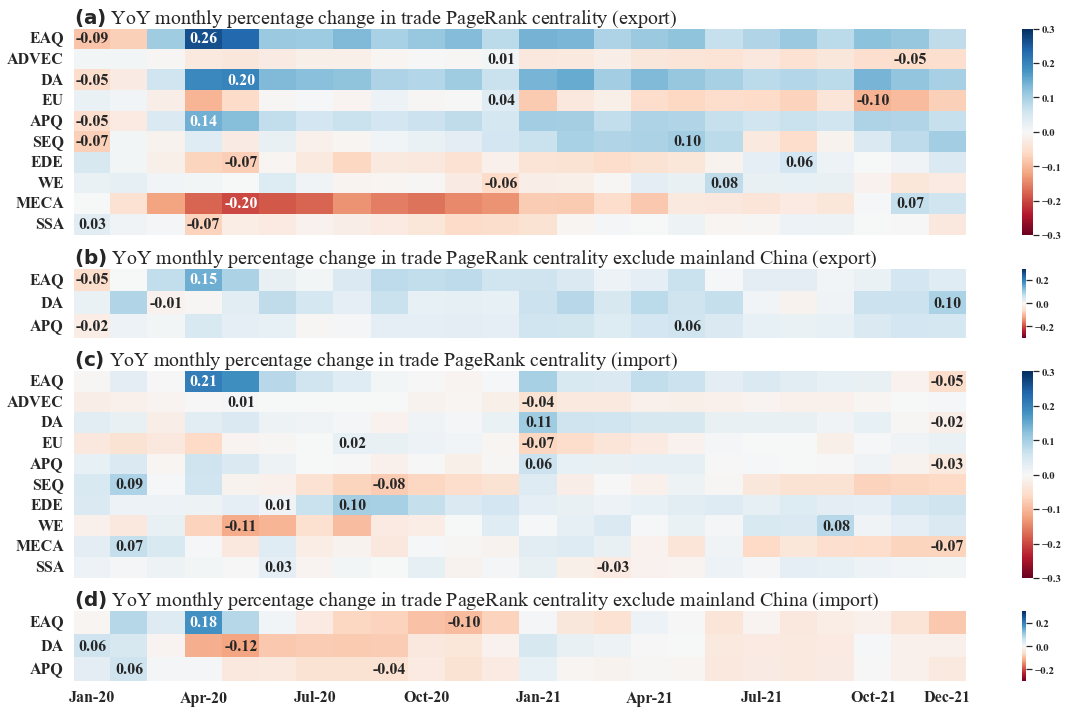

In [10]:
vmax = 0.3

fig = plt.figure(figsize = (20, 12))
plt.subplots_adjust(hspace = 40)

#--------------------------------------------------------------------------------------------------------
axes = plt.subplot2grid((20, 1), (0, 0), rowspan = 7)
axes.set_title(r'$\bf{(a)}$ YoY monthly percentage change in trade PageRank centrality (export)', fontsize = 20, loc = 'left')

data = RegionalYoY[['region', 'year', 'month', 'ex_pr']].\
    pivot(index = 'region', columns = ['year', 'month'], values = 'ex_pr').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False)
pdata = data.iloc[:,1:-1]
pdata.index = data['region']

sns.heatmap(pdata.iloc[:], ax = axes, cmap='RdBu', annot = show_only_min_and_max(pdata), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes.set_xticklabels(labels = X_AXIS, visible = False)
axes.set_xlabel('')
axes.set_ylabel('')
axes.set_yticklabels(labels = axes.get_yticklabels(), rotation = 0, fontsize = 16)

#--------------------------------------------------------------------------------------------------------
axes = plt.subplot2grid((20, 1), (7, 0), rowspan = 3)
axes.set_title(r'$\bf{(b)}$ YoY monthly percentage change in trade PageRank centrality exclude mainland China (export)', fontsize = 20, loc = 'left')

data = RegionalYoY_NoCHN[['region', 'year', 'month', 'ex_pr']].\
    pivot(index = 'region', columns = ['year', 'month'], values = 'ex_pr').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False)
pdata = data.iloc[:,1:-1]
pdata.index = data['region']

sns.heatmap(pdata.iloc[:], ax = axes, cmap='RdBu', annot = show_only_min_and_max(pdata), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes.set_xlabel('')
axes.set_ylabel('')
axes.set_xticklabels(labels = X_AXIS, visible = False)
axes.set_yticklabels(labels = axes.get_yticklabels(), rotation = 0, fontsize = 16)

#--------------------------------------------------------------------------------------------------------
axes = plt.subplot2grid((20, 1), (10, 0), rowspan = 7)
axes.set_title(r'$\bf{(c)}$ YoY monthly percentage change in trade PageRank centrality (import)', fontsize = 20, loc = 'left')

data = RegionalYoY[['region', 'year', 'month', 'im_pr']].\
    pivot(index = 'region', columns = ['year', 'month'], values = 'im_pr').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False)
pdata = data.iloc[:,1:-1]
pdata.index = data['region']

sns.heatmap(pdata.iloc[:], ax = axes, cmap='RdBu', annot = show_only_min_and_max(pdata), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes.set_xlabel('')
axes.set_ylabel('')
axes.set_xticklabels(labels = X_AXIS, visible = False)
axes.set_yticklabels(labels = axes.get_yticklabels(), rotation = 0, fontsize = 16)

#--------------------------------------------------------------------------------------------------------
axes = plt.subplot2grid((20, 1), (17, 0), rowspan = 3)
axes.set_title(r'$\bf{(d)}$ YoY monthly percentage change in trade PageRank centrality exclude mainland China (import)', fontsize = 20, loc = 'left')

data = RegionalYoY_NoCHN[['region', 'year', 'month', 'im_pr']].\
    pivot(index = 'region', columns = ['year', 'month'], values = 'im_pr').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False)
pdata = data.iloc[:,1:-1]
pdata.index = data['region']

sns.heatmap(pdata.iloc[:], ax = axes, cmap='RdBu', annot = show_only_min_and_max(pdata), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes.set_xlabel('')
axes.set_ylabel('')
axes.set_xticklabels(labels = X_AXIS, rotation = 0, fontsize = 16)
axes.set_yticklabels(labels = axes.get_yticklabels(), rotation = 0, fontsize = 16)

#--------------------------------------------------------------------------------------------------------
plt.show()
fig.savefig(r'Plots/Figure 4.jpg', bbox_inches = 'tight', dpi = 300)

## 2.3 Country/Area Scale (Section 3.1.3)

In [11]:
CountryScaleAll = GlobalAttrs

CountryScaleRef = CountryScaleAll.\
    query('year == 2018 or year == 2019').\
    reset_index().\
    groupby(['month', 'ISO3']).\
    mean().\
    drop(columns = ['year']).\
    reset_index()

CountryScaleYoY = CountryScaleAll.\
    query('year == 2020 or year == 2021').\
    reset_index().\
    merge(CountryScaleRef, on = ['month', 'ISO3']).\
    eval('''
        ex_vol = ex_vol_x / ex_vol_y - 1
        im_vol = im_vol_x / im_vol_y - 1
        ex_pr = ex_pr_x / ex_pr_y - 1
        im_pr = im_pr_x / im_pr_y - 1
    ''').\
    filter(regex = r'^((?!_[xy]).)*$').\
    sort_values(['year', 'month'])

CountryScaleYoY.to_excel('Tables/CountryScaleYoY.xlsx', sheet_name = 'CountryScaleYoY', index = False)

C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\504553243.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = CountryScaleYoY.\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\504553243.py:20: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = CountryScaleYoY.\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\504553243.py:32: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = CountryScaleYoY.\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\504553243.py:44: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = CountryScaleYoY.\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\50

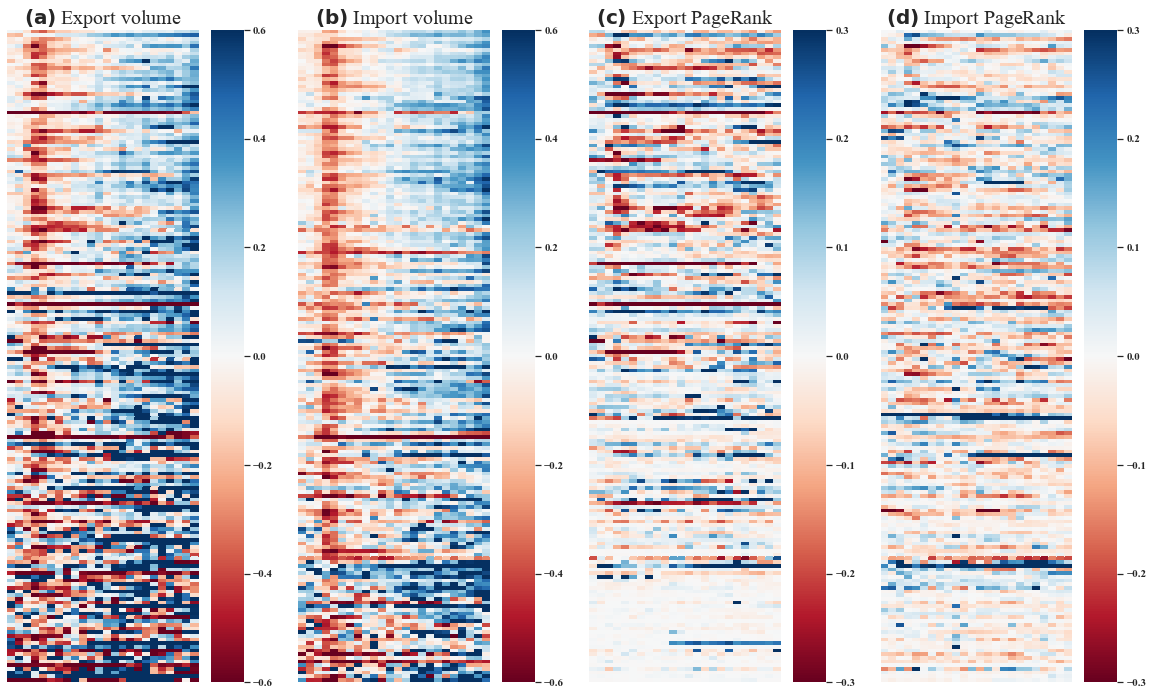

In [12]:
vmax_vol, vmax_pr = 0.6, 0.3

fig, axes = plt.subplots(1, 4, figsize = (20, 12))

#--------------------------------------------------------------------------------------------------------
axes[0].set_title(r'$\bf{(a)}$ Export volume', fontsize = 20)

data = CountryScaleYoY.\
    reset_index().\
    pivot(index = 'ISO3', columns = ['year', 'month'], values = 'ex_vol').\
    merge(AreasGdp, on = 'ISO3').\
    sort_values('gdp', ascending = False).\
    iloc[:, 1:-1]
sns.heatmap(data, ax = axes[0], cmap = 'RdBu', center = 0, vmax = vmax_vol, vmin = -vmax_vol, 
            xticklabels = False, yticklabels = False, cbar_kws = {'fraction': 0.16})

#--------------------------------------------------------------------------------------------------------
axes[1].set_title(r'$\bf{(b)}$ Import volume', fontsize = 20)

data = CountryScaleYoY.\
    reset_index().\
    pivot(index = 'ISO3', columns = ['year', 'month'], values = 'im_vol').\
    merge(AreasGdp, on = 'ISO3').\
    sort_values('gdp', ascending = False).\
    iloc[:, 1:-1]
sns.heatmap(data, ax = axes[1], cmap = 'RdBu', center = 0, vmax = vmax_vol, vmin = -vmax_vol, 
            xticklabels = False, yticklabels = False, cbar_kws = {'fraction': 0.16})

#--------------------------------------------------------------------------------------------------------
axes[2].set_title(r'$\bf{(c)}$ Export PageRank', fontsize = 20)

data = CountryScaleYoY.\
    reset_index().\
    pivot(index = 'ISO3', columns = ['year', 'month'], values = 'ex_pr').\
    merge(AreasGdp, on = 'ISO3').\
    sort_values('gdp', ascending = False).\
    iloc[:, 1:-1]
sns.heatmap(data, ax = axes[2], cmap = 'RdBu', center = 0, vmax = vmax_pr, vmin = -vmax_pr, 
            xticklabels = False, yticklabels = False, cbar_kws = {'fraction': 0.16})

#--------------------------------------------------------------------------------------------------------
axes[3].set_title(r'$\bf{(d)}$ Import PageRank', fontsize = 20)

data = CountryScaleYoY.\
    reset_index().\
    pivot(index = 'ISO3', columns = ['year', 'month'], values = 'im_pr').\
    merge(AreasGdp, on = 'ISO3').\
    sort_values('gdp', ascending = False).\
    iloc[:, 1:-1]
sns.heatmap(data, ax = axes[3], cmap = 'RdBu', center = 0, vmax = vmax_pr, vmin = -vmax_pr, 
            xticklabels = False, yticklabels = False, cbar_kws = {'fraction': 0.16})

#--------------------------------------------------------------------------------------------------------
fig.show()
fig.savefig(r'Plots/Figure 7.jpg', bbox_inches = 'tight', dpi = 300)

# 3 Intra-Regional and Inter-Regional Interconnectedness (Section 3.2)

## 3.1 Intra- & Inter- Regional Volume

In [13]:
IntraRegionalAll = IntraRegionalAttrs.\
    groupby(['region', 'year', 'month']).\
    agg({
        'ex_vol': numpy.sum
    }).\
    rename(columns = {'ex_vol': 'intra_vol'})

IntraRegionalRef = IntraRegionalAll.\
    query('year == 2018 or year == 2019').\
    reset_index().\
    groupby(['month', 'region']).\
    mean().\
    drop(columns = ['year']).\
    reset_index()

IntraRegionalYoY = IntraRegionalAll.\
    query('year == 2020 or year == 2021').\
    reset_index().\
    merge(IntraRegionalRef, on = ['month', 'region']).\
    eval('''
        intra_vol = intra_vol_x / intra_vol_y - 1
    ''').\
    filter(regex = r'^((?!_[xy]).)*$').\
    sort_values(['region', 'year', 'month'])

writer = pandas.ExcelWriter('Tables/Intra-Inter-RegionalYoY.xlsx')
IntraRegionalYoY.to_excel(writer, sheet_name = 'IntraRegionalYoY', index = False)

In [14]:
InterRegionalAll = InterRegionalAttrs.\
    groupby(['region_x', 'region_y', 'year', 'month']).\
    agg({
        'ex_vol': numpy.sum
    }).\
    rename(columns = {'ex_vol': 'inter_vol'})

InterRegionalRef = InterRegionalAll.\
    query('year == 2018 or year == 2019').\
    reset_index().\
    groupby(['month', 'region_x', 'region_y']).\
    mean().\
    drop(columns = ['year']).\
    reset_index()

InterRegionalYoY = InterRegionalAll.\
    query('year == 2020 or year == 2021').\
    reset_index().\
    merge(InterRegionalRef, on = ['month', 'region_x', 'region_y']).\
    eval('''
        inter_vol = inter_vol_x / inter_vol_y - 1
    ''').\
    drop(columns = ['inter_vol_x', 'inter_vol_y']).\
    sort_values(['region_x', 'region_y', 'year', 'month'])

InterRegionalYoY.to_excel(writer, sheet_name = 'InterRegionalYoY', index = False)
writer.save()

C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\534845053.py:9: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = IntraRegionalYoY.\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\534845053.py:40: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  InterData_1 = InterRegionalYoY.\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\534845053.py:43: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  InterData_2 = InterRegionalYoY.\


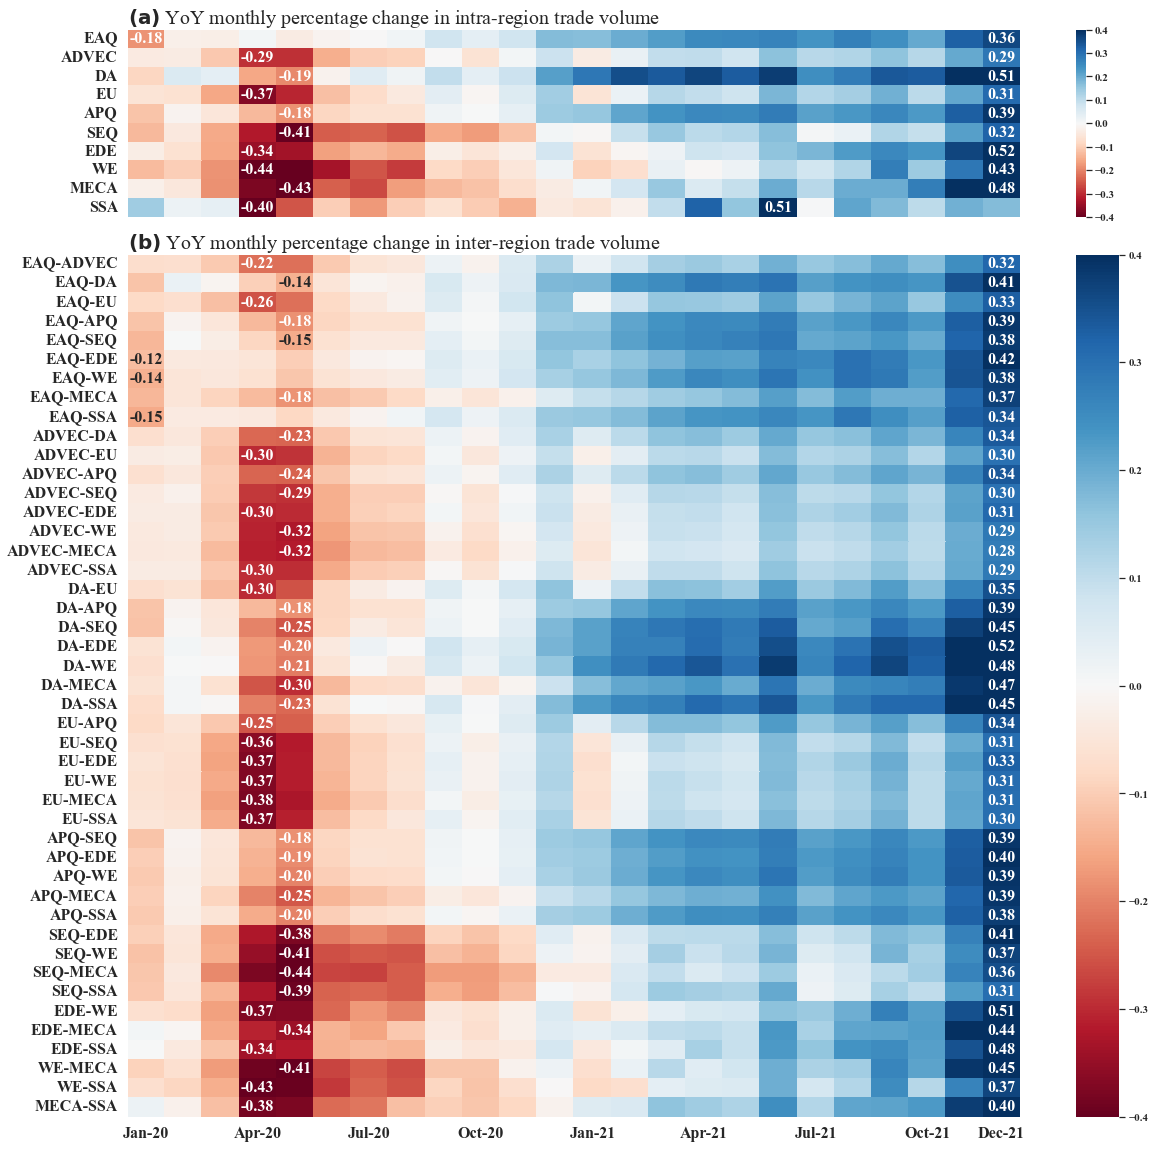

In [15]:
vmax = 0.4

fig = plt.figure(figsize = (20, 20))

#--------------------------------------------------------------------------------------------------------
axes = plt.subplot2grid((5, 1), (0, 0))
axes.set_title(r'$\bf{(a)}$ YoY monthly percentage change in intra-region trade volume', fontsize = 20, loc = 'left')

data = IntraRegionalYoY.\
    pivot(index = 'region', columns = ['year', 'month'], values = 'intra_vol').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False)
pdata = data.iloc[:,1:-1]
pdata.index = data['region']

sns.heatmap(pdata.iloc[:], ax = axes, cmap='RdBu', annot = show_only_min_and_max(pdata), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes.set_xticklabels(labels = X_AXIS, visible = False)
axes.set_yticklabels(labels = axes.get_yticklabels(), fontsize = 16)
axes.set_xlabel('')
axes.set_ylabel('')

#--------------------------------------------------------------------------------------------------------
axes = plt.subplot2grid((5, 1), (1, 0), rowspan = 4)
axes.set_title(r'$\bf{(b)}$ YoY monthly percentage change in inter-region trade volume', fontsize = 20, loc = 'left')

RegionsByGdp = RegionsGdp.\
    sort_values('avg_gdp', ascending = False).\
    loc[:,'region'].\
    to_list()
InterRegions = pandas.DataFrame(
    [
        (RegionsByGdp[i], RegionsByGdp[j]) 
        for i in range(len(RegionsByGdp))
        for j in range(i, len(RegionsByGdp))
    ],
    columns = ['region_x', 'region_y']
).\
    reset_index()

InterData_1 = InterRegionalYoY.\
    pivot(index = ['region_x', 'region_y'], columns = ['year', 'month'], values = 'inter_vol').\
    merge(InterRegions, on = ['region_x', 'region_y'])
InterData_2 = InterRegionalYoY.\
    pivot(index = ['region_x', 'region_y'], columns = ['year', 'month'], values = 'inter_vol').\
    merge(InterRegions, left_on = ['region_x', 'region_y'], right_on = ['region_y', 'region_x'])

data = pandas.concat([InterData_1, InterData_2]).\
    sort_values('index')
pdata = data.iloc[:,2:-1]
pdata.index = [x + '-' + y for x, y in zip(data['region_x'], data['region_y'])]

sns.heatmap(pdata.iloc[:], ax = axes, cmap='RdBu', annot = show_only_min_and_max(pdata), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes.set_xlabel('')
axes.set_ylabel('')
axes.set_xticklabels(labels = X_AXIS, rotation = 0, fontsize = 16)
axes.set_yticklabels(labels = axes.get_yticklabels(), fontsize = 16)

#--------------------------------------------------------------------------------------------------------
plt.show()
fig.savefig(r'Plots/Figure B.2.jpg', bbox_inches = 'tight', dpi = 300)

## 3.2 Regionalization

In [16]:
RgnztAll = RegionalAll.\
    drop(columns = ['ex_pr', 'im_pr']).\
    rename(columns = {
        'ex_vol': 'ex_vol_glb',
        'im_vol': 'im_vol_glb'
    }).\
    merge(IntraRegionalAll, on = ['region', 'year', 'month']).\
    eval('''
        ex_rgnzt = intra_vol / ex_vol_glb
        im_rgnzt = intra_vol / im_vol_glb
    ''').\
    drop(columns = ['ex_vol_glb', 'im_vol_glb', 'intra_vol'])

RgnztRef = RgnztAll.\
    query('year == 2018 or year == 2019').\
    reset_index().\
    groupby(['month', 'region']).\
    mean().\
    drop(columns = ['year']).\
    reset_index()

RgnztYoY = RgnztAll.\
    query('year == 2020 or year == 2021').\
    reset_index().\
    merge(RgnztRef, on = ['month', 'region']).\
    eval('''
        ex_rgnzt = ex_rgnzt_x / ex_rgnzt_y - 1
        im_rgnzt = im_rgnzt_x / im_rgnzt_y - 1
    ''').\
    filter(regex = r'^((?!_[xy]).)*$').\
    sort_values(['region', 'year', 'month'])

RgnztYoY.to_excel('Tables/RegionalizationYoY.xlsx', sheet_name = 'RegionalizationYoY', index = False)

C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\499719565.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = RgnztYoY[['region', 'year', 'month', 'ex_rgnzt']].\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\499719565.py:23: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  data = RgnztYoY[['region', 'year', 'month', 'im_rgnzt']].\
C:\Users\PiesPro\AppData\Local\Temp\ipykernel_5632\499719565.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


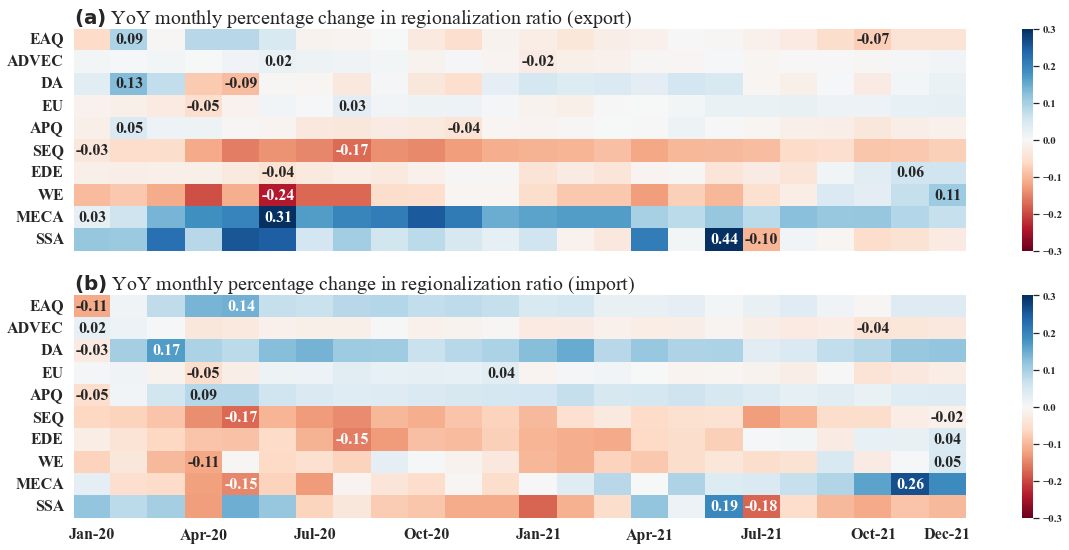

In [17]:
vmax = 0.3

fig, axes = plt.subplots(2, 1, figsize = (20, 9))

#--------------------------------------------------------------------------------------------------------
axes[0].set_title(r'$\bf{(a)}$ YoY monthly percentage change in regionalization ratio (export)', fontsize = 20, loc = 'left')

data = RgnztYoY[['region', 'year', 'month', 'ex_rgnzt']].\
    pivot(index = 'region', columns = ['year', 'month'], values = 'ex_rgnzt').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False).\
    drop(columns = ['avg_gdp']).\
    set_index('region')
sns.heatmap(data, ax = axes[0], cmap = 'RdBu', annot = show_only_min_and_max(data), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[0].set_xticklabels(labels = X_AXIS, visible = False)
axes[0].set_yticklabels(labels = axes[0].get_yticklabels(), fontsize = 16)

#--------------------------------------------------------------------------------------------------------
axes[1].set_title(r'$\bf{(b)}$ YoY monthly percentage change in regionalization ratio (import)', fontsize = 20, loc = 'left')

data = RgnztYoY[['region', 'year', 'month', 'im_rgnzt']].\
    pivot(index = 'region', columns = ['year', 'month'], values = 'im_rgnzt').\
    merge(RegionsGdp, on = 'region').\
    sort_values('avg_gdp', ascending = False).\
    drop(columns = ['avg_gdp']).\
    set_index('region')
sns.heatmap(data, ax = axes[1], cmap = 'RdBu', annot = show_only_min_and_max(data), fmt='', center = 0, vmax = vmax, vmin = -vmax)
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_xticklabels(labels = X_AXIS, rotation = 0, fontsize = 16)
axes[1].set_yticklabels(labels = axes[1].get_yticklabels(), fontsize = 16)

#--------------------------------------------------------------------------------------------------------
fig.show()
fig.savefig(r'Plots/Figure 5.jpg', bbox_inches = 'tight', dpi = 300)